# Project - Vehicle Detection 

## 0. Import

In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from utility import *
from process import *
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn import grid_search

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Features and Channels

In [5]:
cars, notcars = smalldata_list('data_small/*/*/*.jpeg')

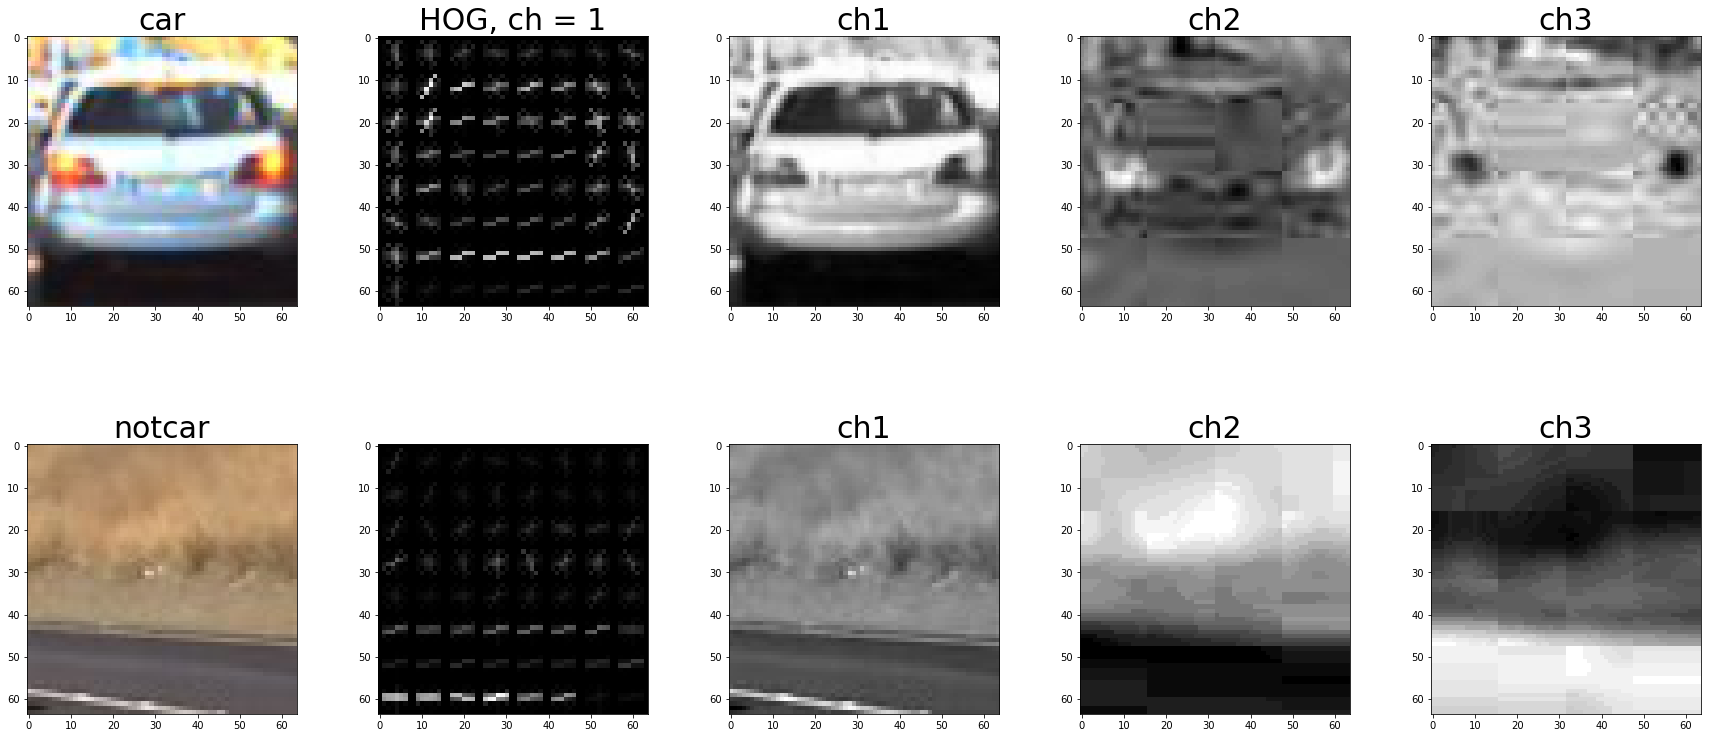

In [7]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

RGB_car = mpimg.imread(cars[car_ind])
RGB_notcar = mpimg.imread(notcars[notcar_ind])
channel_car = cv2.cvtColor(RGB_car, cv2.COLOR_RGB2YUV)
channel_notcar = cv2.cvtColor(RGB_notcar, cv2.COLOR_RGB2YUV)

channel = 0
orient = 9
pix_per_cell = 8
cell_per_block =2
_, hog_car = get_hog_features(channel_car[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_notcar = get_hog_features(channel_notcar[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, axes = plt.subplots(2, 5, figsize=(30,15))
axes = axes.ravel()
axes[0].imshow(RGB_car)
axes[0].set_title('car', fontsize=30)
axes[1].imshow(hog_car,cmap='gray')
axes[1].set_title('HOG, ch = ' +str(channel+1), fontsize=30)
axes[2].imshow(channel_car[:,:,0],cmap='gray')
axes[2].set_title('ch1', fontsize=30)
axes[3].imshow(channel_car[:,:,1],cmap='gray')
axes[3].set_title('ch2', fontsize=30)
axes[4].imshow(channel_car[:,:,2],cmap='gray')
axes[4].set_title('ch3', fontsize=30)
axes[5].imshow(RGB_notcar)
axes[5].set_title('notcar', fontsize=30)
axes[6].imshow(hog_notcar,cmap='gray')
axes[1].set_title('HOG, ch = ' +str(channel+1), fontsize=30)
axes[7].imshow(channel_notcar[:,:,0],cmap='gray')
axes[7].set_title('ch1', fontsize=30)
axes[8].imshow(channel_notcar[:,:,1],cmap='gray')
axes[8].set_title('ch2', fontsize=30)
axes[9].imshow(channel_notcar[:,:,2],cmap='gray')
axes[9].set_title('ch3', fontsize=30)
plt.subplots_adjust(wspace=0.3, hspace = 0.0)

## 2. SVM Training

In [8]:
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')
print('total number of car samples: ' +str(len(cars)))
print('total number of notcar samples: ' +str(len(notcars)))

total number of car samples: 8792
total number of notcar samples: 9055


### Global Configurations

In [9]:
config = {}
config['color_space'] = 'YUV'
config['spatial_size']= (32, 32)
config['hist_bins'] = 32
config['orient'] = 9
config['pix_per_cell'] = 8
config['cell_per_block'] = 2      
config['hog_channel'] = 'ALL'
config['spatial_feat'] = True
config['hist_feat']  = True
config['hog_feat']  = True

### Feature Extraction

In [10]:
car_features = extract_features(filenames = cars, config = config)

image format = 0 - 180
featureimage format = 0 - 174
spatial_features.shape = (3072,)
hist_features.shape = (96,)
hog_features.shape = (5292,)


In [11]:
notcar_features = extract_features(filenames = notcars, config = config)

image format = 0 - 198
featureimage format = 0 - 188
spatial_features.shape = (3072,)
hist_features.shape = (96,)
hog_features.shape = (5292,)


In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

### Grid Search

In [ ]:
parameters = {'C':[0.001,0.01, 0.1, 1, 10, 100]}
linearSVC = svm.LinearSVC()
clf = grid_search.GridSearchCV(linearSVC, parameters, verbose=1)
clf.fit(X_train, y_train)
clf.best_params_
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))

### Linear SVM

In [13]:
clf2 = svm.LinearSVC()
clf2.fit(X_train, y_train)
print('Test Accuracy of SVC = ', clf2.score(X_test, y_test))

Test Accuracy of SVC =  0.989915966387


### Verification and saving

In [14]:
model = {}
model['SVM'] = clf2
model['X_scaler'] = X_scaler

pickle.dump((model,config), open( "svc_model7.p", "wb" ) )

In [15]:
model_load, config_load = pickle.load( open( "svc_model7.p", "rb" ) )
clf = model_load['SVM']
clf.score(X_test, y_test)

0.98991596638655466

## 3. Multi-scale window search

In [65]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("project_video.mp4")
image1 = clip1.get_frame(18)

In [66]:
model_load, config_load = pickle.load(open( "svc_model7.p", "rb" ))
clf = model_load['SVM']
X_scaler = model_load['X_scaler']
config = config_load
coords = []
coords.append((1,20,1270,400,517))
coords.append((2,7,1280,370,499))
coords.append((3,20,1280,380,580))
coords.append((4,0,1280,380,660))

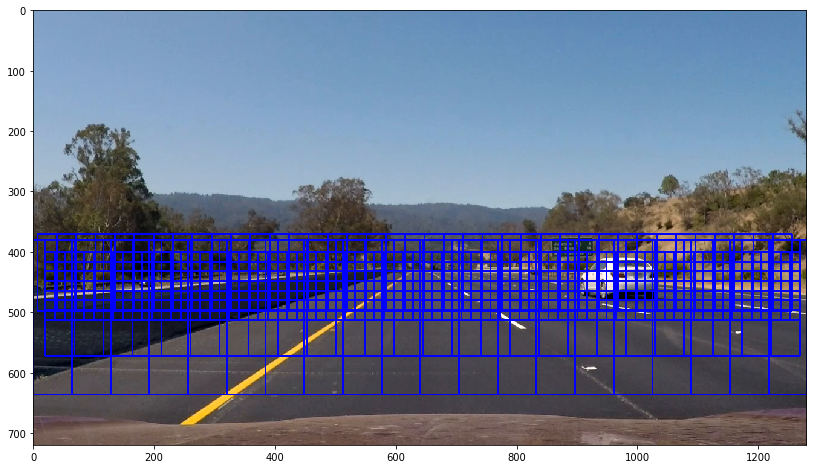

In [61]:
image_draw, box_list, energy_list = find_cars_multi_scales(image1, coords, clf, X_scaler, config)
heatmap = np.zeros_like(image_draw[:,:,0])
current_heatmap = add_heat(heatmap, box_list, energy_list, 1.0)
plt.imshow(image_draw)
plt.gcf().set_size_inches(16, 8)

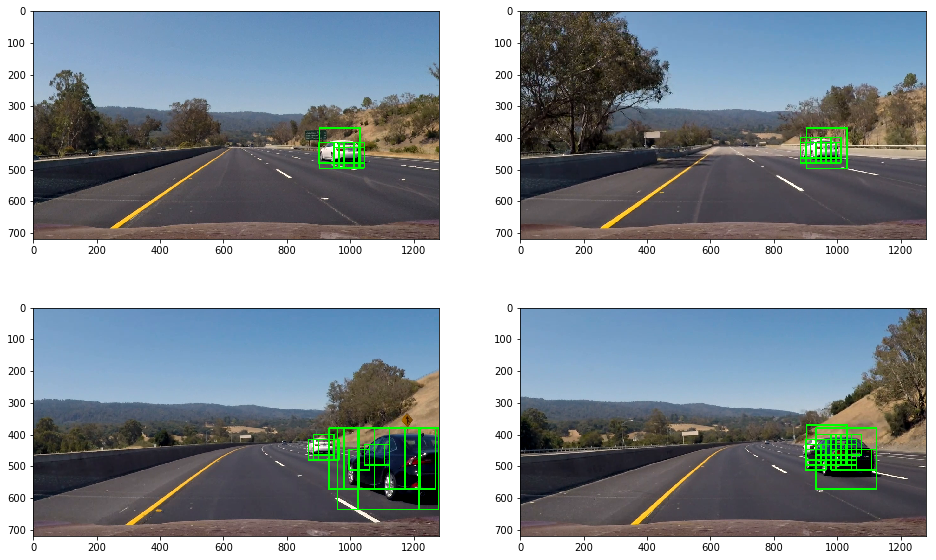

In [82]:
image_draw1, _, _ = find_cars_multi_scales(clip1.get_frame(18), coords, clf, X_scaler, config)
image_draw2, _, _ = find_cars_multi_scales(clip1.get_frame(21), coords, clf, X_scaler, config)
image_draw3, _, _ = find_cars_multi_scales(clip1.get_frame(29), coords, clf, X_scaler, config)
image_draw4, _, _ = find_cars_multi_scales(clip1.get_frame(32), coords, clf, X_scaler, config)
plt.subplot(221)
plt.imshow(image_draw1)
plt.subplot(222)
plt.imshow(image_draw2)
plt.subplot(223)
plt.imshow(image_draw3)
plt.subplot(224)
plt.imshow(image_draw4)
plt.gcf().set_size_inches(16, 10)

## 4. Pipeline and Heatmap

In [98]:
model_load, config_load = pickle.load(open( "svc_model7.p", "rb" ))
clf = model_load['SVM']
X_scaler = model_load['X_scaler']
config = config_load
coords = []
coords.append((1,20,1270,400,517))
coords.append((2,7,1280,370,499))
coords.append((3,20,1280,380,580))
coords.append((4,0,1280,380,660))

In [92]:
clip1 = VideoFileClip("project_video.mp4")
images = []
for frame in clip1.iter_frames():
    images.append(frame)

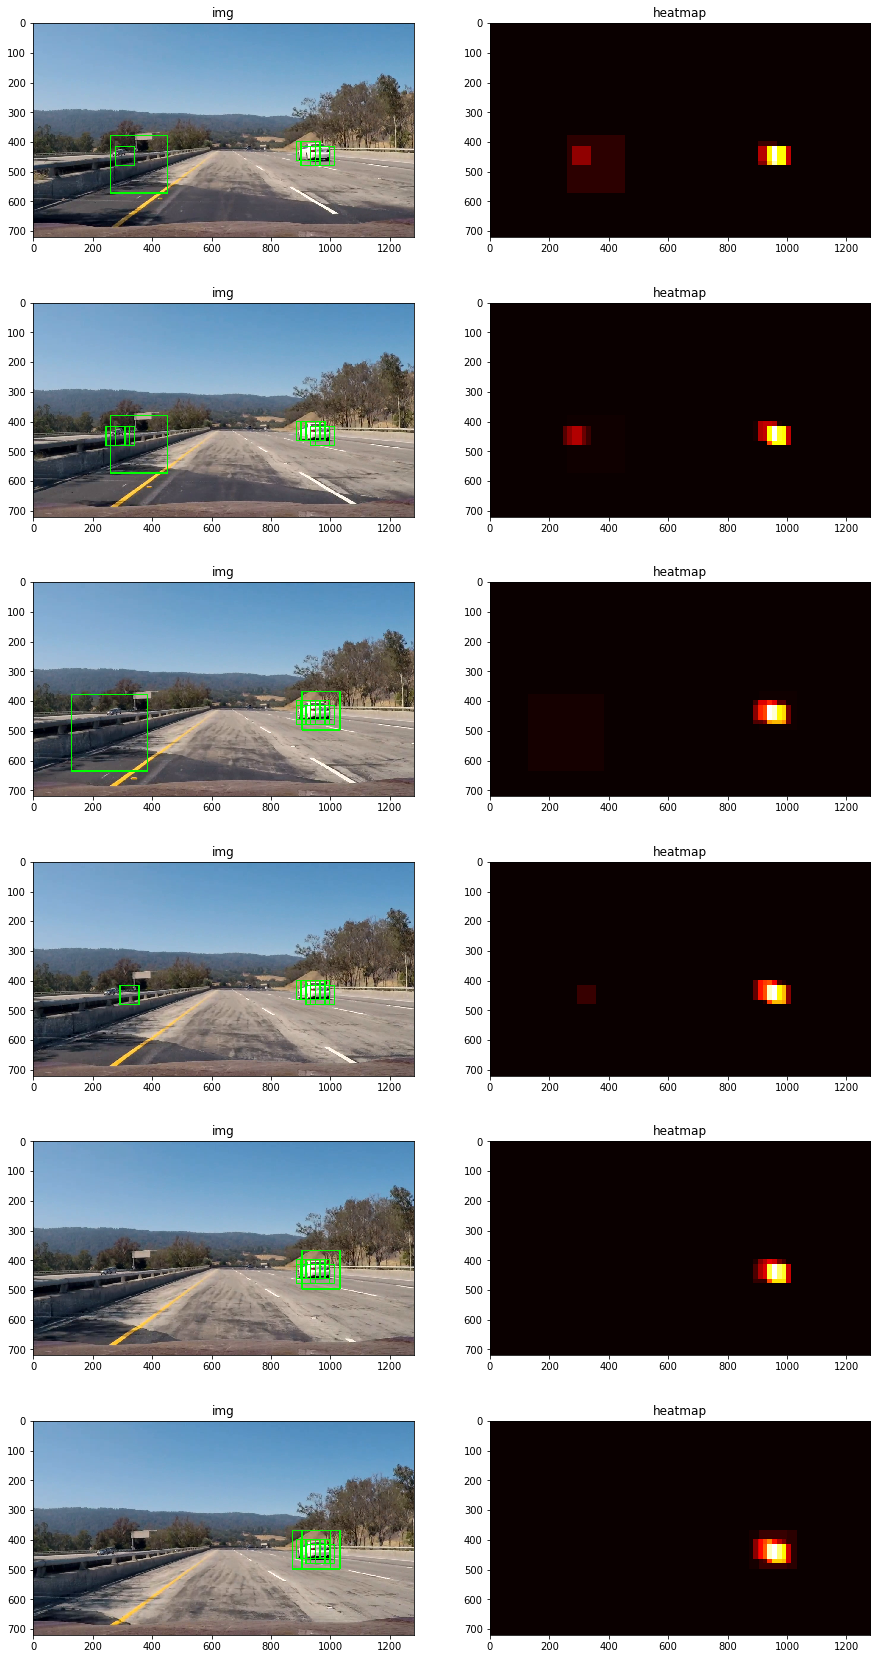

In [131]:
idx_start = 550
images_processed = []
for i in range(6):
    images_processed.append((find_cars_multi_scales(images[i+idx_start], coords, clf, X_scaler, config)))

f, axes = plt.subplots(6, 2, figsize=(15,30))
heatmap = np.zeros_like(images_processed[0][0][:,:,0])
axes = axes.ravel()
for i in range(6):
    image_draw, box_list, energy_list = images_processed[i]
    axes[2*i].imshow(image_draw)
    axes[2*i].set_title('img', fontsize=12)
    axes[2*i+1].imshow(add_heat(heatmap, box_list, energy_list, 1.0),cmap='hot')
    axes[2*i+1].set_title('heatmap', fontsize=12)

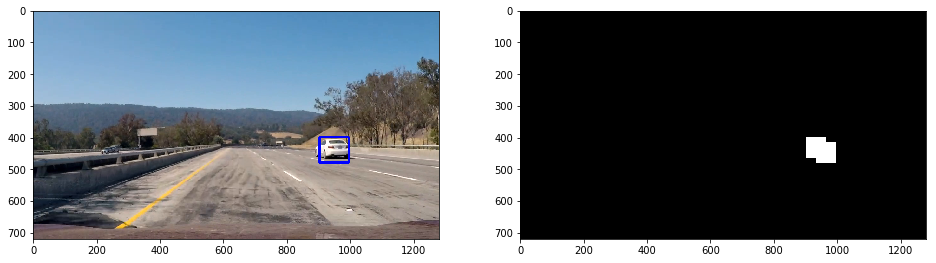

In [142]:
video_test = process_video(coords, clf, X_scaler, config, 1.0)
for i in range(6):
    img_draw = video_test.process_step(images[i+idx_start])
heatmap, labels = video_test.output_heatmap_labels()
plt.subplot(121)
plt.imshow(img_draw)
plt.set_title('img', fontsize=12)
plt.subplot(122)
plt.imshow(labels[0],cmap='gray')
plt.gcf().set_size_inches(16, 16)

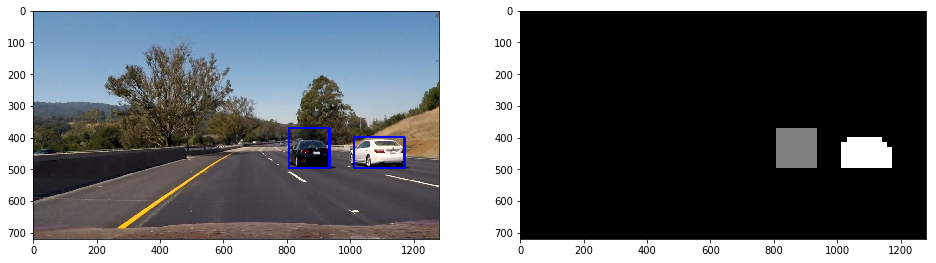

In [151]:
idx_start = 950
video_test = process_video(coords, clf, X_scaler, config, 1.0)
for i in range(6):
    img_draw = video_test.process_step(images[i+idx_start])
heatmap, labels = video_test.output_heatmap_labels()
plt.subplot(121)
plt.imshow(img_draw)
plt.subplot(122)
plt.imshow(labels[0],cmap='gray')
plt.gcf().set_size_inches(16, 16)

### Negative Mining

In [ ]:
box = box_list[4]
image_crop = image_bad[box[1][0]:box[1][1]:,box[0][0]:box[0][1],:]
if image_crop.shape[0] > 64:
    image_crop = cv2.resize(image_crop, (64,64))
image_save = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
plt.imshow(image_crop)

In [ ]:
filename = sorted(glob.glob('data/non-vehicles/Negative/*.png'))
index = int(filename[-1][-6:-4])
cv2.imwrite('data/non-vehicles/Negative/neg'+str(index+1)+'.png',image_save)

## 5. Video

In [144]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

model_load, config_load = pickle.load(open( "svc_model7.p", "rb" ))
clf = model_load['SVM']
X_scaler = model_load['X_scaler']
config = config_load

# th_list = [1.0, 1.2, 1.4 , 1.6, 1.8, 2.0]
th_list = [1.5]
idx = 0
for th in th_list:
    video_v1 = process_video(coords, clf, X_scaler, config, th)

    proj_output = 'output_videos/project_video_output_'+str(idx)+'.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("project_video.mp4")
    proj_clip = clip1.fl_image(video_v1.process_step) #NOTE: this function expects color images!!
    %time proj_clip.write_videofile(proj_output, audio=False)
    idx +=1

[MoviePy] >>>> Building video output_videos/project_video_output_0.mp4
[MoviePy] Writing video output_videos/project_video_output_0.mp4


100%|█████████▉| 1260/1261 [08:55<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output_0.mp4 

CPU times: user 9min 16s, sys: 1.62 s, total: 9min 17s
Wall time: 8min 55s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_output))